#Importar Librerias

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import mysql.connector
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Cargar las variables de entorno del archivo .env

In [2]:
load_dotenv()
db_host = os.getenv('DB_HOST')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_name = os.getenv('DB_NAME')

# Conectar a la base de datos MySQL

In [3]:
conn = mysql.connector.connect(
    host=db_host,
    user=db_user,
    password=db_password,
    database=db_name
)

# Ejecutar la consulta SQL

In [4]:
query = """
SELECT seller_id, sku, created_at, total_orden
FROM production_db.orders
WHERE seller_id IS NOT NULL
  AND created_at >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR)
  AND created_at < DATE_FORMAT(CURDATE(), '%Y-%m-01');
"""

df = pd.read_sql(query, conn)

conn.close()

### Cargar los datos y realizar las transformaciones necesarias

In [5]:
df.columns = ['USUARIO', 'SKU', 'FECHA', 'VENTA']
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d', errors='coerce')
df['PERIODO'] = df['FECHA'].dt.strftime('%Y-%m')
df.set_index('USUARIO', inplace=True)
df['COHORTGROUPO'] = df.groupby(level=0)['FECHA'].transform('min').dt.strftime('%Y-%m')
df.reset_index(inplace=True)
df.head()

,USUARIO,SKU,FECHA,VENTA,PERIODO,COHORTGROUPO
0,51205,M0212202301124951205,2023-12-02 13:42:49,15.98,2023-12,2023-12
1,32335,M0212202306124332335,2023-12-02 18:06:43,18.98,2023-12,2023-12
2,12220,M0212202310122612220,2023-12-02 22:23:26,1.56,2023-12,2023-12
3,52069,M0212202311123352069,2023-12-02 23:32:33,15.98,2023-12,2023-12
4,29707,M0212202311120029707,2023-12-02 23:37:00,25.98,2023-12,2023-12


In [6]:
df.to_csv('data_seller.csv', index=True)

### Agrupar por cohortes y períodos

In [7]:
grouped = df.groupby(['COHORTGROUPO', 'PERIODO'])
cohorts = grouped.agg({'USUARIO': pd.Series.nunique,
                       'SKU': pd.Series.nunique,
                       'VENTA': pd.Series.nunique})
cohorts.head()

USUARIO  SKU  VENTA
COHORTGROUPO PERIODO                     
2023-12      2023-12      133  249     74
             2024-01       40  101     33
             2024-02       31  116     28
             2024-03       24   57     23
             2024-04       20   43     25

### Calcular tamaño del grupo de cohortes

In [8]:
cohort_group_size = cohorts['USUARIO'].groupby(level=0).first()
cohort_group_size.head()

COHORTGROUPO
2023-12    133
2024-01     77
2024-02     47
2024-03     89
2024-04     81
Name: USUARIO, dtype: int64

### Crear matriz de retención en enteros y en porcentaje

In [9]:
retencion_int = cohorts['USUARIO'].unstack(0)  # Datos de retención en enteros
retencion_int.head()

COHORTGROUPO,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
PERIODO,,,,,,,,,,,,
2023-12,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01,40.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02,31.0,21.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03,24.0,14.0,15.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04,20.0,9.0,11.0,20.0,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
retencion_percent = retencion_int.divide(cohort_group_size, axis=1)  # Datos de retención en porcentaje
retencion_percent.head()

COHORTGROUPO,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
PERIODO,,,,,,,,,,,,
2023-12,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01,0.300752,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02,0.233083,0.272727,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03,0.180451,0.181818,0.319149,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04,0.150376,0.116883,0.234043,0.224719,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exportar datos a CSV

In [11]:
retencion_int_t = retencion_int.T
retencion_percent_t = retencion_percent.T

mes_actual = (datetime.now() - relativedelta(months=1)).strftime('%B')


retencion_int_t.to_csv(f'datareten_int_seller_{mes_actual}.csv', index=True)
retencion_percent_t.to_csv(f'datareten_percent_seller_{mes_actual}.csv', index=True)

### Configurar tamaño de figura y crear el primer gráfico (porcentaje)

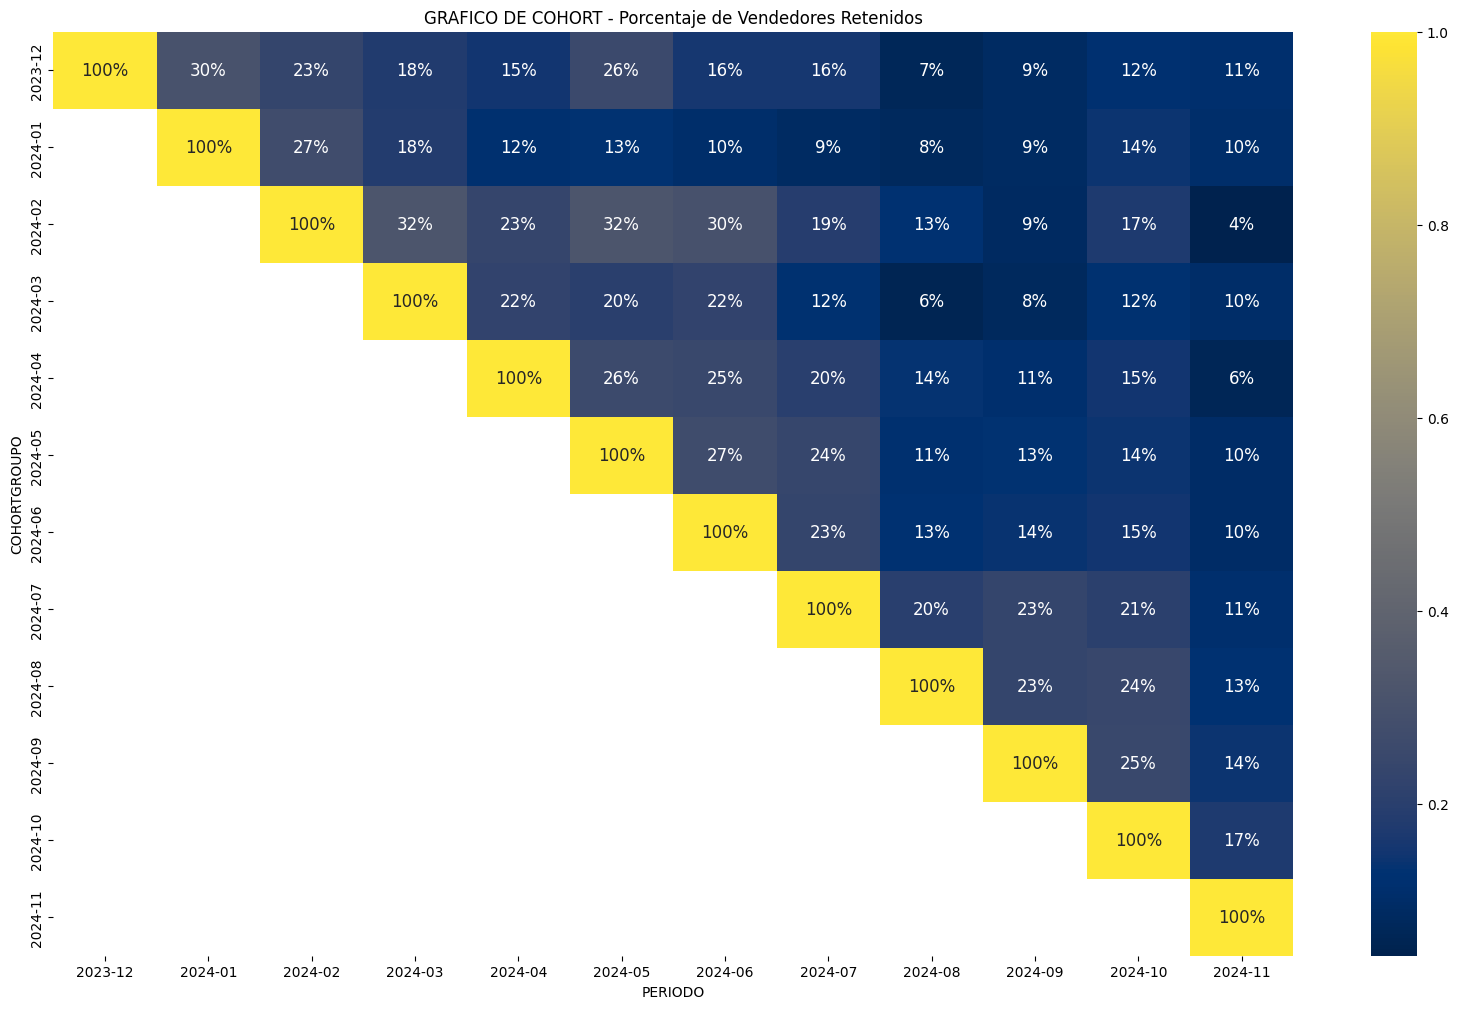

In [12]:
porcentaje = retencion_percent.T
plt.figure(figsize=(20, 12))
plt.title('GRAFICO DE COHORT - Porcentaje de Vendedores Retenidos')
sns.heatmap(data=porcentaje,
            annot=True,
            fmt=".0%",  # Formato de porcentaje sin decimales
            annot_kws={'size': 12},  # Tamaño de las anotaciones
            cbar=True,
            cmap='cividis')
plt.savefig(f'datareten_percent_seller_{mes_actual}.png')
plt.show()

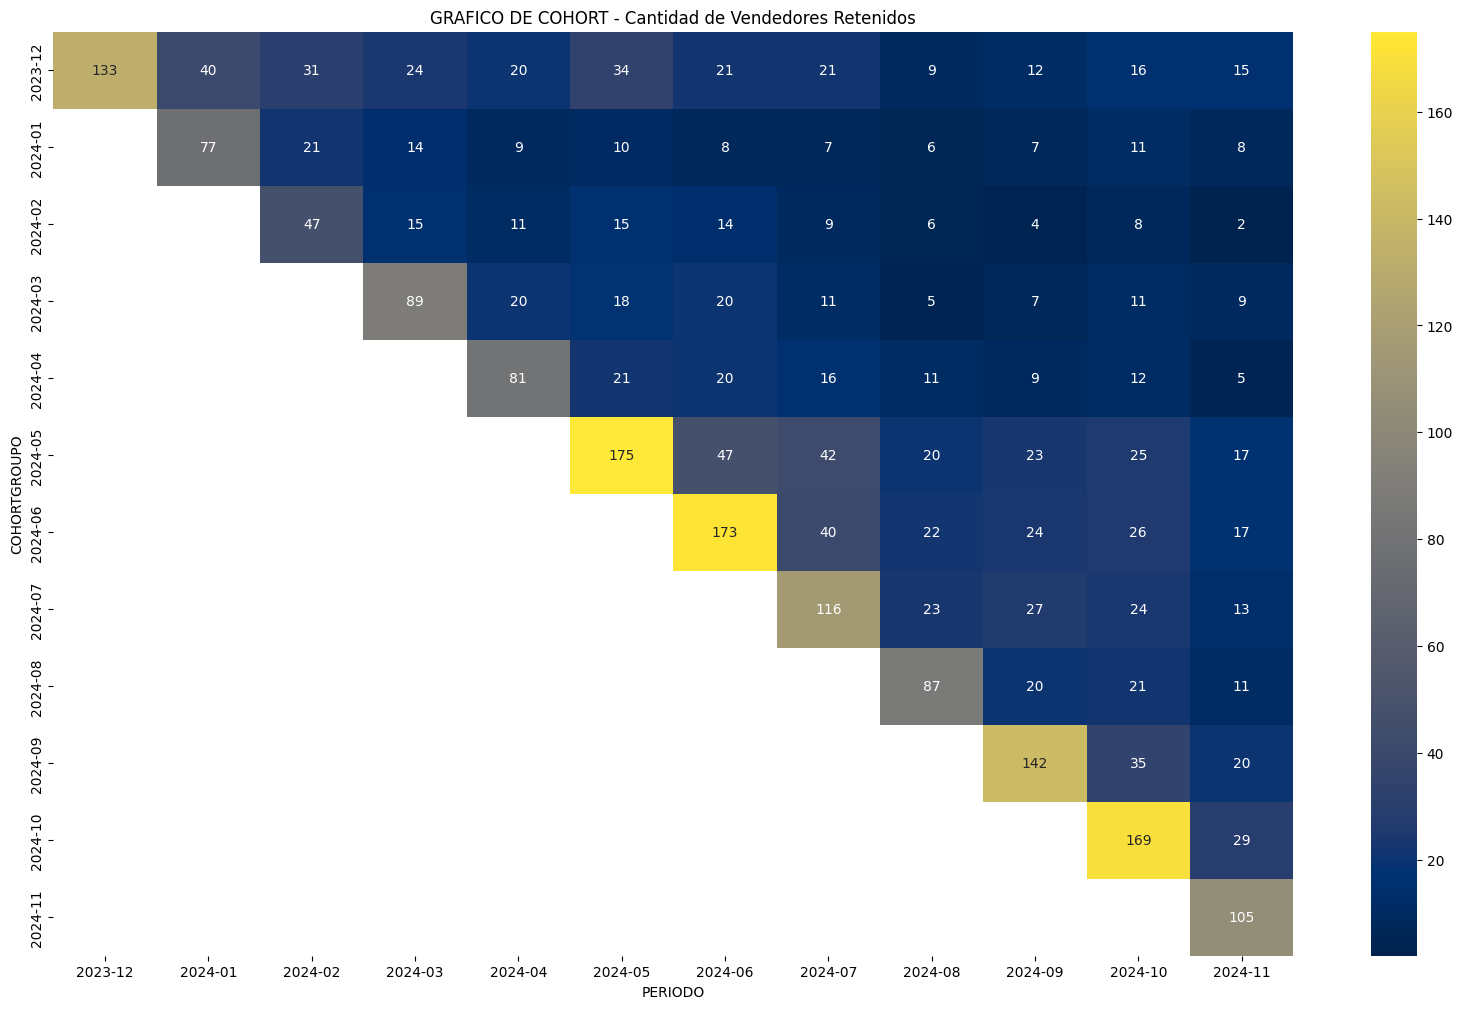

In [13]:
# Llena NaNs con valor nulo (None)
retencion_int = retencion_int.where(pd.notnull(retencion_int), None)

# Configura tamaño de figura y crea el gráfico
plt.figure(figsize=(20, 12))
plt.title('GRAFICO DE COHORT - Cantidad de Vendedores Retenidos')
sns.heatmap(data=retencion_int.T,
            annot=True,
            fmt=".0f",  # Formato para números float sin decimales
            annot_kws={'size': 10},  # Tamaño de las anotaciones
            cbar=True,
            cmap='cividis')
plt.savefig(f'datareten_int_seller_{mes_actual}.png')
plt.show()
